In [14]:
import os
import numpy as np
import pandas as pd
import pickle as pl

from plotnine import *

os.chdir("/Users/cornederuijt/github/GCM/") # Adjust after construction of the package

from scripts.clickmodel_fitters.clickdefinitionreader import ClickDefinition
from scripts.clickmodel_fitters.GCM import GCM

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import Zeros

np.random.seed(1992)

In [15]:
class SimpleDense(Layer):
    def __init__(self, units=11):
        super(SimpleDense, self).__init__()
        self.units = units

    def build(self, input_shape):  # Create the state of the layer (weights)
        T = self.units - 1  # As we exclude the zero state for now
        zero_init = tf.zeros_initializer()

        self._w = tf.Variable(initial_value=zero_init(shape=(int(T * (T + 1) / 2),), dtype='float32'), trainable=True)
        self._zero_col_var = tf.Variable(initial_value=zero_init(shape=(T + 1, 1), dtype='float32'), trainable=False)
        self._zero_row_var = tf.Variable(initial_value=zero_init(shape=(1, T), dtype='float32'), trainable=False)

        # mask:
        t1 = tf.ones((T+1, T+1), dtype="float32")
        t2 = tf.subtract(t1, tf.eye(T+1, dtype="float32"))
        self._wout_mask = tf.multiply(tf.linalg.band_part(t1, 0, -1), t2)

    def call(self, inputs, **kwargs):  # Defines the computation from inputs to outputs
        # print(tf.shape(inputs)[0])
        N = inputs.shape[0]
        T = self.units
        inp_lst = []

        wout = tfp.math.fill_triangular(self._w, upper=True)
        wout = tf.concat([wout, self._zero_row_var], axis=0)
        wout = tf.concat([self._zero_col_var, wout], axis=1)

        for t in range(N):
            cur_input = tf.gather(inputs, t, axis=0)
            cur_input = tf.tile(tf.reshape(cur_input, shape=(1, -1)), [T, 1])
            logis = tf.multiply(cur_input, wout)

            cur_mask = tf.multiply(cur_input, self._wout_mask)

            inp_lst.append(tf.reshape(
                tf.multiply(tf.transpose(tf.transpose(tf.exp(logis)) / tf.reduce_sum(tf.exp(logis), axis=1)),
                              cur_mask), shape=(1, -1)))

        res = tf.concat(inp_lst, axis=0)

        return res

In [3]:
# Define the model
list_size = 10
no_states = 11
ubm_click_states = np.eye(list_size + 1, list_size + 1)
abs_state = [(i, i) for i in range(no_states)]
init_state = 0
batch_size = 10000
no_items = 100

var_dic = {
    'phi_A': {
        'var_type': 'item',
        'pos_mat': np.triu(np.ones((list_size + 1, list_size + 1)), k=1)
    },
    'gamma': {
        'var_type': 'pos',
        'pos_mat': np.triu(np.ones((list_size + 1, list_size + 1)), k=1)
    }
}

model_def = ClickDefinition(ubm_click_states, init_state, list_size, no_states, batch_size, no_items, abs_state,
                            var_dic)

In [4]:
# Load data:
click_data = pd.read_csv("./data/small_example/simulation_res_train.csv", index_col=False)
prod_position = pd.read_csv("./data/small_example/simulation_item_props.csv", index_col=False)

# Ensure the order is correct:
click_data = click_data.sort_values(['user_id', 'session_count', 'item_order'])

# Add session index:
session_index = (click_data
                 .loc[:, ['user_id', 'session_count']]
                 .drop_duplicates()
                 .reset_index()
                 )

session_index['session'] = session_index.index.to_numpy()

click_data = (click_data
              .set_index(['user_id', 'session_count'])
              .join(session_index
                    .set_index(['user_id', 'session_count']),
                    on=['user_id', 'session_count'])
              .reset_index()
              .set_index('item')
              .join(prod_position
                    .set_index('item'),
                    on='item')
              .reset_index()
              )

click_data



,item,user_id,session_count,item_order,click,attr,satis,eval,orig_list_id,index,session,X0,X1
0,42,0,0,1,0.0,0,0,1.0,0,0,0,-0.617880,-0.424150
1,66,0,0,2,0.0,0,0,1.0,0,0,0,-0.463804,-0.667938
2,89,0,0,3,0.0,0,0,1.0,0,0,0,-0.849402,1.813430
3,64,0,0,4,0.0,0,0,1.0,0,0,0,-1.875517,-1.026840
4,25,0,0,5,0.0,0,0,1.0,0,0,0,-0.908807,0.050236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250565,85,17999,2,6,0.0,0,0,0.0,35807,250560,25056,-0.362179,-0.737943
250566,3,17999,2,7,0.0,1,0,0.0,35807,250560,25056,0.136692,0.039374
250567,76,17999,2,8,0.0,1,0,0.0,35807,250560,25056,0.257214,-0.653226
250568,64,17999,2,9,0.0,0,0,0.0,35807,250560,25056,-1.875517,-1.026840


In [5]:
# Create the click matrix and item position matrix
click_mat = click_data.loc[:, ['session', 'item_order', 'click']] \
    .pivot(index='session', columns='item_order', values='click') \
    .to_numpy()

item_pos_mat = click_data.loc[:, ['session', 'item_order', 'item']] \
    .pivot(index='session', columns='item_order', values='item') \
    .to_numpy()

# Ensure the order is correct
item_feature_mat_A = (click_data.loc[:, ['item', 'X0', 'X1']]
                                .drop_duplicates()
                                .sort_values('item')
                                .to_numpy())

pos_feature_gamma = np.eye(model_def.list_size, model_def.list_size + 1, k=1)

var_dic = {'phi_A': item_feature_mat_A, 'gamma': pos_feature_gamma}

In [16]:
# Model:
model_phi_A = Sequential()
model_phi_A.add(Dense(1, input_dim=var_dic['phi_A'].shape[1], activation='sigmoid', use_bias=False,
                     kernel_initializer=Zeros()))
model_phi_A.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())

# Note the large output dimension and the softmax. We want multiple transition probabilities that sum up to 1
# Its the shape**2, as we flatten the square matrix.
model_gamma = Sequential()
model_gamma.add(SimpleDense(no_states))
model_gamma.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())

# model_tau = Sequential()
# model_tau.add(Dense(var_dic['tau'].shape[1], input_dim=var_dic['tau'].shape[1], activation=None, use_bias=False,
#                     kernel_initializer=Identity(), trainable=False))
# model_tau.compile('rmsprop', 'binary_crossentropy')  # No trainable weights, so doesn't really matter

var_models = {'phi_A': model_phi_A, 'gamma': model_gamma}

In [17]:
res = GCM.runEM(click_mat, var_dic, var_models, item_pos_mat, model_def, verbose=True,n_jobs=1)

Iteration: 0
Running E-step ...
Current conditional entropy:0.47464
Running M-step ...
Epoch 1/250
1/1 - 0s - loss: 0.6931
Epoch 2/250
1/1 - 0s - loss: 0.6186
Epoch 3/250
1/1 - 0s - loss: 0.5721
Epoch 4/250
1/1 - 0s - loss: 0.5373
Epoch 5/250
1/1 - 0s - loss: 0.5091
Epoch 6/250
1/1 - 0s - loss: 0.4853
Epoch 7/250
1/1 - 0s - loss: 0.4647
Epoch 8/250
1/1 - 0s - loss: 0.4465
Epoch 9/250
1/1 - 0s - loss: 0.4301
Epoch 10/250
1/1 - 0s - loss: 0.4152
Epoch 11/250
1/1 - 0s - loss: 0.4017
Epoch 12/250
1/1 - 0s - loss: 0.3892
Epoch 13/250
1/1 - 0s - loss: 0.3776
Epoch 14/250
1/1 - 0s - loss: 0.3668
Epoch 15/250
1/1 - 0s - loss: 0.3567
Epoch 16/250
1/1 - 0s - loss: 0.3472
Epoch 17/250
1/1 - 0s - loss: 0.3382
Epoch 18/250
1/1 - 0s - loss: 0.3298
Epoch 19/250
1/1 - 0s - loss: 0.3217
Epoch 20/250
1/1 - 0s - loss: 0.3141
Epoch 21/250
1/1 - 0s - loss: 0.3069
Epoch 22/250
1/1 - 0s - loss: 0.3000
Epoch 23/250
1/1 - 0s - loss: 0.2934
Epoch 24/250
1/1 - 0s - loss: 0.2870
Epoch 25/250
1/1 - 0s - loss: 0.28

1/1 - 0s - loss: 0.0535
Epoch 178/250
1/1 - 0s - loss: 0.0532
Epoch 179/250
1/1 - 0s - loss: 0.0528
Epoch 180/250
1/1 - 0s - loss: 0.0525
Epoch 181/250
1/1 - 0s - loss: 0.0522
Epoch 182/250
1/1 - 0s - loss: 0.0518
Epoch 183/250
1/1 - 0s - loss: 0.0515
Epoch 184/250
1/1 - 0s - loss: 0.0512
Epoch 185/250
1/1 - 0s - loss: 0.0509
Epoch 186/250
1/1 - 0s - loss: 0.0505
Epoch 187/250
1/1 - 0s - loss: 0.0502
Epoch 188/250
1/1 - 0s - loss: 0.0499
Epoch 189/250
1/1 - 0s - loss: 0.0496
Epoch 190/250
1/1 - 0s - loss: 0.0493
Epoch 191/250
1/1 - 0s - loss: 0.0490
Epoch 192/250
1/1 - 0s - loss: 0.0487
Epoch 193/250
1/1 - 0s - loss: 0.0484
Epoch 194/250
1/1 - 0s - loss: 0.0481
Epoch 195/250
1/1 - 0s - loss: 0.0478
Epoch 196/250
1/1 - 0s - loss: 0.0475
Epoch 197/250
1/1 - 0s - loss: 0.0473
Epoch 198/250
1/1 - 0s - loss: 0.0470
Epoch 199/250
1/1 - 0s - loss: 0.0467
Epoch 200/250
1/1 - 0s - loss: 0.0464
Epoch 201/250
1/1 - 0s - loss: 0.0462
Epoch 202/250
1/1 - 0s - loss: 0.0459
Epoch 203/250
1/1 - 0s - l

Epoch 132/250
1/1 - 0s - loss: 11.3208
Epoch 133/250
1/1 - 0s - loss: 11.3208
Epoch 134/250
1/1 - 0s - loss: 11.3208
Epoch 135/250
1/1 - 0s - loss: 11.3208
Epoch 136/250
1/1 - 0s - loss: 11.3207
Epoch 137/250
1/1 - 0s - loss: 11.3207
Epoch 138/250
1/1 - 0s - loss: 11.3207
Epoch 139/250
1/1 - 0s - loss: 11.3207
Epoch 140/250
1/1 - 0s - loss: 11.3207
Epoch 141/250
1/1 - 0s - loss: 11.3207
Epoch 142/250
1/1 - 0s - loss: 11.3206
Epoch 143/250
1/1 - 0s - loss: 11.3206
Epoch 144/250
1/1 - 0s - loss: 11.3206
Epoch 145/250
1/1 - 0s - loss: 11.3206
Epoch 146/250
1/1 - 0s - loss: 11.3205
Epoch 147/250
1/1 - 0s - loss: 11.3205
Epoch 148/250
1/1 - 0s - loss: 11.3205
Epoch 149/250
1/1 - 0s - loss: 11.3205
Epoch 150/250
1/1 - 0s - loss: 11.3205
Epoch 151/250
1/1 - 0s - loss: 11.3205
Epoch 152/250
1/1 - 0s - loss: 11.3204
Epoch 153/250
1/1 - 0s - loss: 11.3204
Epoch 154/250
1/1 - 0s - loss: 11.3204
Epoch 155/250
1/1 - 0s - loss: 11.3204
Epoch 156/250
1/1 - 0s - loss: 11.3204
Epoch 157/250
1/1 - 0s - 

Epoch 95/250
1/1 - 0s - loss: 0.0241
Epoch 96/250
1/1 - 0s - loss: 0.0240
Epoch 97/250
1/1 - 0s - loss: 0.0239
Epoch 98/250
1/1 - 0s - loss: 0.0238
Epoch 99/250
1/1 - 0s - loss: 0.0238
Epoch 100/250
1/1 - 0s - loss: 0.0237
Epoch 101/250
1/1 - 0s - loss: 0.0236
Epoch 102/250
1/1 - 0s - loss: 0.0235
Epoch 103/250
1/1 - 0s - loss: 0.0234
Epoch 104/250
1/1 - 0s - loss: 0.0233
Epoch 105/250
1/1 - 0s - loss: 0.0233
Epoch 106/250
1/1 - 0s - loss: 0.0232
Epoch 107/250
1/1 - 0s - loss: 0.0231
Epoch 108/250
1/1 - 0s - loss: 0.0230
Epoch 109/250
1/1 - 0s - loss: 0.0230
Epoch 110/250
1/1 - 0s - loss: 0.0229
Epoch 111/250
1/1 - 0s - loss: 0.0228
Epoch 112/250
1/1 - 0s - loss: 0.0227
Epoch 113/250
1/1 - 0s - loss: 0.0227
Epoch 114/250
1/1 - 0s - loss: 0.0226
Epoch 115/250
1/1 - 0s - loss: 0.0225
Epoch 116/250
1/1 - 0s - loss: 0.0224
Epoch 117/250
1/1 - 0s - loss: 0.0224
Epoch 118/250
1/1 - 0s - loss: 0.0223
Epoch 119/250
1/1 - 0s - loss: 0.0222
Epoch 120/250
1/1 - 0s - loss: 0.0221
Epoch 121/250
1/1

Epoch 61/250
1/1 - 0s - loss: 11.3175
Epoch 62/250
1/1 - 0s - loss: 11.3175
Epoch 63/250
1/1 - 0s - loss: 11.3175
Epoch 64/250
1/1 - 0s - loss: 11.3175
Epoch 65/250
1/1 - 0s - loss: 11.3174
Epoch 66/250
1/1 - 0s - loss: 11.3174
Epoch 67/250
1/1 - 0s - loss: 11.3174
Epoch 68/250
1/1 - 0s - loss: 11.3174
Epoch 69/250
1/1 - 0s - loss: 11.3174
Epoch 70/250
1/1 - 0s - loss: 11.3174
Epoch 71/250
1/1 - 0s - loss: 11.3173
Epoch 72/250
1/1 - 0s - loss: 11.3173
Epoch 73/250
1/1 - 0s - loss: 11.3173
Epoch 74/250
1/1 - 0s - loss: 11.3173
Epoch 75/250
1/1 - 0s - loss: 11.3173
Epoch 76/250
1/1 - 0s - loss: 11.3172
Epoch 77/250
1/1 - 0s - loss: 11.3172
Epoch 78/250
1/1 - 0s - loss: 11.3172
Epoch 79/250
1/1 - 0s - loss: 11.3172
Epoch 80/250
1/1 - 0s - loss: 11.3172
Epoch 81/250
1/1 - 0s - loss: 11.3172
Epoch 82/250
1/1 - 0s - loss: 11.3171
Epoch 83/250
1/1 - 0s - loss: 11.3171
Epoch 84/250
1/1 - 0s - loss: 11.3171
Epoch 85/250
1/1 - 0s - loss: 11.3171
Epoch 86/250
1/1 - 0s - loss: 11.3171
Epoch 87/250

Epoch 21/250
1/1 - 0s - loss: 0.0148
Epoch 22/250
1/1 - 0s - loss: 0.0148
Epoch 23/250
1/1 - 0s - loss: 0.0147
Epoch 24/250
1/1 - 0s - loss: 0.0147
Epoch 25/250
1/1 - 0s - loss: 0.0147
Epoch 26/250
1/1 - 0s - loss: 0.0146
Epoch 27/250
1/1 - 0s - loss: 0.0146
Epoch 28/250
1/1 - 0s - loss: 0.0146
Epoch 29/250
1/1 - 0s - loss: 0.0145
Epoch 30/250
1/1 - 0s - loss: 0.0145
Epoch 31/250
1/1 - 0s - loss: 0.0145
Epoch 32/250
1/1 - 0s - loss: 0.0144
Epoch 33/250
1/1 - 0s - loss: 0.0144
Epoch 34/250
1/1 - 0s - loss: 0.0144
Epoch 35/250
1/1 - 0s - loss: 0.0144
Epoch 36/250
1/1 - 0s - loss: 0.0143
Epoch 37/250
1/1 - 0s - loss: 0.0143
Epoch 38/250
1/1 - 0s - loss: 0.0143
Epoch 39/250
1/1 - 0s - loss: 0.0142
Epoch 40/250
1/1 - 0s - loss: 0.0142
Epoch 41/250
1/1 - 0s - loss: 0.0142
Epoch 42/250
1/1 - 0s - loss: 0.0141
Epoch 43/250
1/1 - 0s - loss: 0.0141
Epoch 44/250
1/1 - 0s - loss: 0.0141
Epoch 45/250
1/1 - 0s - loss: 0.0140
Epoch 46/250
1/1 - 0s - loss: 0.0140
Epoch 47/250
1/1 - 0s - loss: 0.0140
E

Epoch 239/250
1/1 - 0s - loss: 0.0099
Epoch 240/250
1/1 - 0s - loss: 0.0099
Epoch 241/250
1/1 - 0s - loss: 0.0098
Epoch 242/250
1/1 - 0s - loss: 0.0098
Epoch 243/250
1/1 - 0s - loss: 0.0098
Epoch 244/250
1/1 - 0s - loss: 0.0098
Epoch 245/250
1/1 - 0s - loss: 0.0098
Epoch 246/250
1/1 - 0s - loss: 0.0098
Epoch 247/250
1/1 - 0s - loss: 0.0098
Epoch 248/250
1/1 - 0s - loss: 0.0097
Epoch 249/250
1/1 - 0s - loss: 0.0097
Epoch 250/250
1/1 - 0s - loss: 0.0097
Epoch 1/250
1/1 - 0s - loss: 11.3141
Epoch 2/250
1/1 - 0s - loss: 11.3141
Epoch 3/250
1/1 - 0s - loss: 11.3141
Epoch 4/250
1/1 - 0s - loss: 11.3140
Epoch 5/250
1/1 - 0s - loss: 11.3140
Epoch 6/250
1/1 - 0s - loss: 11.3140
Epoch 7/250
1/1 - 0s - loss: 11.3140
Epoch 8/250
1/1 - 0s - loss: 11.3140
Epoch 9/250
1/1 - 0s - loss: 11.3140
Epoch 10/250
1/1 - 0s - loss: 11.3139
Epoch 11/250
1/1 - 0s - loss: 11.3139
Epoch 12/250
1/1 - 0s - loss: 11.3139
Epoch 13/250
1/1 - 0s - loss: 11.3139
Epoch 14/250
1/1 - 0s - loss: 11.3139
Epoch 15/250
1/1 - 0s

Epoch 202/250
1/1 - 0s - loss: 11.3106
Epoch 203/250
1/1 - 0s - loss: 11.3106
Epoch 204/250
1/1 - 0s - loss: 11.3105
Epoch 205/250
1/1 - 0s - loss: 11.3105
Epoch 206/250
1/1 - 0s - loss: 11.3105
Epoch 207/250
1/1 - 0s - loss: 11.3105
Epoch 208/250
1/1 - 0s - loss: 11.3105
Epoch 209/250
1/1 - 0s - loss: 11.3105
Epoch 210/250
1/1 - 0s - loss: 11.3104
Epoch 211/250
1/1 - 0s - loss: 11.3104
Epoch 212/250
1/1 - 0s - loss: 11.3104
Epoch 213/250
1/1 - 0s - loss: 11.3104
Epoch 214/250
1/1 - 0s - loss: 11.3104
Epoch 215/250
1/1 - 0s - loss: 11.3103
Epoch 216/250
1/1 - 0s - loss: 11.3103
Epoch 217/250
1/1 - 0s - loss: 11.3103
Epoch 218/250
1/1 - 0s - loss: 11.3103
Epoch 219/250
1/1 - 0s - loss: 11.3103
Epoch 220/250
1/1 - 0s - loss: 11.3103
Epoch 221/250
1/1 - 0s - loss: 11.3102
Epoch 222/250
1/1 - 0s - loss: 11.3102
Epoch 223/250
1/1 - 0s - loss: 11.3102
Epoch 224/250
1/1 - 0s - loss: 11.3102
Epoch 225/250
1/1 - 0s - loss: 11.3102
Epoch 226/250
1/1 - 0s - loss: 11.3102
Epoch 227/250
1/1 - 0s - 

Epoch 166/250
1/1 - 0s - loss: 0.0076
Epoch 167/250
1/1 - 0s - loss: 0.0076
Epoch 168/250
1/1 - 0s - loss: 0.0076
Epoch 169/250
1/1 - 0s - loss: 0.0076
Epoch 170/250
1/1 - 0s - loss: 0.0076
Epoch 171/250
1/1 - 0s - loss: 0.0076
Epoch 172/250
1/1 - 0s - loss: 0.0076
Epoch 173/250
1/1 - 0s - loss: 0.0076
Epoch 174/250
1/1 - 0s - loss: 0.0076
Epoch 175/250
1/1 - 0s - loss: 0.0075
Epoch 176/250
1/1 - 0s - loss: 0.0075
Epoch 177/250
1/1 - 0s - loss: 0.0075
Epoch 178/250
1/1 - 0s - loss: 0.0075
Epoch 179/250
1/1 - 0s - loss: 0.0075
Epoch 180/250
1/1 - 0s - loss: 0.0075
Epoch 181/250
1/1 - 0s - loss: 0.0075
Epoch 182/250
1/1 - 0s - loss: 0.0075
Epoch 183/250
1/1 - 0s - loss: 0.0075
Epoch 184/250
1/1 - 0s - loss: 0.0075
Epoch 185/250
1/1 - 0s - loss: 0.0074
Epoch 186/250
1/1 - 0s - loss: 0.0074
Epoch 187/250
1/1 - 0s - loss: 0.0074
Epoch 188/250
1/1 - 0s - loss: 0.0074
Epoch 189/250
1/1 - 0s - loss: 0.0074
Epoch 190/250
1/1 - 0s - loss: 0.0074
Epoch 191/250
1/1 - 0s - loss: 0.0074
Epoch 192/25

1/1 - 0s - loss: 11.3075
Epoch 132/250
1/1 - 0s - loss: 11.3075
Epoch 133/250
1/1 - 0s - loss: 11.3075
Epoch 134/250
1/1 - 0s - loss: 11.3075
Epoch 135/250
1/1 - 0s - loss: 11.3075
Epoch 136/250
1/1 - 0s - loss: 11.3074
Epoch 137/250
1/1 - 0s - loss: 11.3074
Epoch 138/250
1/1 - 0s - loss: 11.3074
Epoch 139/250
1/1 - 0s - loss: 11.3074
Epoch 140/250
1/1 - 0s - loss: 11.3074
Epoch 141/250
1/1 - 0s - loss: 11.3074
Epoch 142/250
1/1 - 0s - loss: 11.3073
Epoch 143/250
1/1 - 0s - loss: 11.3073
Epoch 144/250
1/1 - 0s - loss: 11.3073
Epoch 145/250
1/1 - 0s - loss: 11.3073
Epoch 146/250
1/1 - 0s - loss: 11.3073
Epoch 147/250
1/1 - 0s - loss: 11.3073
Epoch 148/250
1/1 - 0s - loss: 11.3072
Epoch 149/250
1/1 - 0s - loss: 11.3072
Epoch 150/250
1/1 - 0s - loss: 11.3072
Epoch 151/250
1/1 - 0s - loss: 11.3072
Epoch 152/250
1/1 - 0s - loss: 11.3072
Epoch 153/250
1/1 - 0s - loss: 11.3072
Epoch 154/250
1/1 - 0s - loss: 11.3071
Epoch 155/250
1/1 - 0s - loss: 11.3071
Epoch 156/250
1/1 - 0s - loss: 11.3071


Epoch 94/250
1/1 - 0s - loss: 0.0061
Epoch 95/250
1/1 - 0s - loss: 0.0061
Epoch 96/250
1/1 - 0s - loss: 0.0061
Epoch 97/250
1/1 - 0s - loss: 0.0061
Epoch 98/250
1/1 - 0s - loss: 0.0061
Epoch 99/250
1/1 - 0s - loss: 0.0061
Epoch 100/250
1/1 - 0s - loss: 0.0061
Epoch 101/250
1/1 - 0s - loss: 0.0061
Epoch 102/250
1/1 - 0s - loss: 0.0060
Epoch 103/250
1/1 - 0s - loss: 0.0060
Epoch 104/250
1/1 - 0s - loss: 0.0060
Epoch 105/250
1/1 - 0s - loss: 0.0060
Epoch 106/250
1/1 - 0s - loss: 0.0060
Epoch 107/250
1/1 - 0s - loss: 0.0060
Epoch 108/250
1/1 - 0s - loss: 0.0060
Epoch 109/250
1/1 - 0s - loss: 0.0060
Epoch 110/250
1/1 - 0s - loss: 0.0060
Epoch 111/250
1/1 - 0s - loss: 0.0060
Epoch 112/250
1/1 - 0s - loss: 0.0060
Epoch 113/250
1/1 - 0s - loss: 0.0060
Epoch 114/250
1/1 - 0s - loss: 0.0060
Epoch 115/250
1/1 - 0s - loss: 0.0060
Epoch 116/250
1/1 - 0s - loss: 0.0059
Epoch 117/250
1/1 - 0s - loss: 0.0059
Epoch 118/250
1/1 - 0s - loss: 0.0059
Epoch 119/250
1/1 - 0s - loss: 0.0059
Epoch 120/250
1/1 

Epoch 60/250
1/1 - 0s - loss: 11.3046
Epoch 61/250
1/1 - 0s - loss: 11.3046
Epoch 62/250
1/1 - 0s - loss: 11.3046
Epoch 63/250
1/1 - 0s - loss: 11.3046
Epoch 64/250
1/1 - 0s - loss: 11.3045
Epoch 65/250
1/1 - 0s - loss: 11.3045
Epoch 66/250
1/1 - 0s - loss: 11.3045
Epoch 67/250
1/1 - 0s - loss: 11.3045
Epoch 68/250
1/1 - 0s - loss: 11.3045
Epoch 69/250
1/1 - 0s - loss: 11.3045
Epoch 70/250
1/1 - 0s - loss: 11.3044
Epoch 71/250
1/1 - 0s - loss: 11.3044
Epoch 72/250
1/1 - 0s - loss: 11.3044
Epoch 73/250
1/1 - 0s - loss: 11.3044
Epoch 74/250
1/1 - 0s - loss: 11.3044
Epoch 75/250
1/1 - 0s - loss: 11.3044
Epoch 76/250
1/1 - 0s - loss: 11.3043
Epoch 77/250
1/1 - 0s - loss: 11.3043
Epoch 78/250
1/1 - 0s - loss: 11.3043
Epoch 79/250
1/1 - 0s - loss: 11.3043
Epoch 80/250
1/1 - 0s - loss: 11.3043
Epoch 81/250
1/1 - 0s - loss: 11.3043
Epoch 82/250
1/1 - 0s - loss: 11.3042
Epoch 83/250
1/1 - 0s - loss: 11.3042
Epoch 84/250
1/1 - 0s - loss: 11.3042
Epoch 85/250
1/1 - 0s - loss: 11.3042
Epoch 86/250

Epoch 20/250
1/1 - 0s - loss: 0.0050
Epoch 21/250
1/1 - 0s - loss: 0.0050
Epoch 22/250
1/1 - 0s - loss: 0.0050
Epoch 23/250
1/1 - 0s - loss: 0.0050
Epoch 24/250
1/1 - 0s - loss: 0.0050
Epoch 25/250
1/1 - 0s - loss: 0.0050
Epoch 26/250
1/1 - 0s - loss: 0.0050
Epoch 27/250
1/1 - 0s - loss: 0.0049
Epoch 28/250
1/1 - 0s - loss: 0.0049
Epoch 29/250
1/1 - 0s - loss: 0.0049
Epoch 30/250
1/1 - 0s - loss: 0.0049
Epoch 31/250
1/1 - 0s - loss: 0.0049
Epoch 32/250
1/1 - 0s - loss: 0.0049
Epoch 33/250
1/1 - 0s - loss: 0.0049
Epoch 34/250
1/1 - 0s - loss: 0.0049
Epoch 35/250
1/1 - 0s - loss: 0.0049
Epoch 36/250
1/1 - 0s - loss: 0.0049
Epoch 37/250
1/1 - 0s - loss: 0.0049
Epoch 38/250
1/1 - 0s - loss: 0.0049
Epoch 39/250
1/1 - 0s - loss: 0.0049
Epoch 40/250
1/1 - 0s - loss: 0.0049
Epoch 41/250
1/1 - 0s - loss: 0.0049
Epoch 42/250
1/1 - 0s - loss: 0.0049
Epoch 43/250
1/1 - 0s - loss: 0.0049
Epoch 44/250
1/1 - 0s - loss: 0.0049
Epoch 45/250
1/1 - 0s - loss: 0.0049
Epoch 46/250
1/1 - 0s - loss: 0.0048
E

Epoch 238/250
1/1 - 0s - loss: 0.0040
Epoch 239/250
1/1 - 0s - loss: 0.0040
Epoch 240/250
1/1 - 0s - loss: 0.0039
Epoch 241/250
1/1 - 0s - loss: 0.0039
Epoch 242/250
1/1 - 0s - loss: 0.0039
Epoch 243/250
1/1 - 0s - loss: 0.0039
Epoch 244/250
1/1 - 0s - loss: 0.0039
Epoch 245/250
1/1 - 0s - loss: 0.0039
Epoch 246/250
1/1 - 0s - loss: 0.0039
Epoch 247/250
1/1 - 0s - loss: 0.0039
Epoch 248/250
1/1 - 0s - loss: 0.0039
Epoch 249/250
1/1 - 0s - loss: 0.0039
Epoch 250/250
1/1 - 0s - loss: 0.0039
Epoch 1/250
1/1 - 0s - loss: 11.3016
Epoch 2/250
1/1 - 0s - loss: 11.3016
Epoch 3/250
1/1 - 0s - loss: 11.3016
Epoch 4/250
1/1 - 0s - loss: 11.3015
Epoch 5/250
1/1 - 0s - loss: 11.3015
Epoch 6/250
1/1 - 0s - loss: 11.3015
Epoch 7/250
1/1 - 0s - loss: 11.3015
Epoch 8/250
1/1 - 0s - loss: 11.3015
Epoch 9/250
1/1 - 0s - loss: 11.3015
Epoch 10/250
1/1 - 0s - loss: 11.3015
Epoch 11/250
1/1 - 0s - loss: 11.3014
Epoch 12/250
1/1 - 0s - loss: 11.3014
Epoch 13/250
1/1 - 0s - loss: 11.3014
Epoch 14/250
1/1 - 0s

1/1 - 0s - loss: 11.2986
Epoch 202/250
1/1 - 0s - loss: 11.2986
Epoch 203/250
1/1 - 0s - loss: 11.2986
Epoch 204/250
1/1 - 0s - loss: 11.2986
Epoch 205/250
1/1 - 0s - loss: 11.2985
Epoch 206/250
1/1 - 0s - loss: 11.2985
Epoch 207/250
1/1 - 0s - loss: 11.2985
Epoch 208/250
1/1 - 0s - loss: 11.2985
Epoch 209/250
1/1 - 0s - loss: 11.2985
Epoch 210/250
1/1 - 0s - loss: 11.2985
Epoch 211/250
1/1 - 0s - loss: 11.2985
Epoch 212/250
1/1 - 0s - loss: 11.2985
Epoch 213/250
1/1 - 0s - loss: 11.2984
Epoch 214/250
1/1 - 0s - loss: 11.2984
Epoch 215/250
1/1 - 0s - loss: 11.2984
Epoch 216/250
1/1 - 0s - loss: 11.2984
Epoch 217/250
1/1 - 0s - loss: 11.2984
Epoch 218/250
1/1 - 0s - loss: 11.2984
Epoch 219/250
1/1 - 0s - loss: 11.2983
Epoch 220/250
1/1 - 0s - loss: 11.2983
Epoch 221/250
1/1 - 0s - loss: 11.2983
Epoch 222/250
1/1 - 0s - loss: 11.2983
Epoch 223/250
1/1 - 0s - loss: 11.2983
Epoch 224/250
1/1 - 0s - loss: 11.2983
Epoch 225/250
1/1 - 0s - loss: 11.2983
Epoch 226/250
1/1 - 0s - loss: 11.2982


Epoch 166/250
1/1 - 0s - loss: 0.0033
Epoch 167/250
1/1 - 0s - loss: 0.0033
Epoch 168/250
1/1 - 0s - loss: 0.0033
Epoch 169/250
1/1 - 0s - loss: 0.0033
Epoch 170/250
1/1 - 0s - loss: 0.0033
Epoch 171/250
1/1 - 0s - loss: 0.0033
Epoch 172/250
1/1 - 0s - loss: 0.0033
Epoch 173/250
1/1 - 0s - loss: 0.0033
Epoch 174/250
1/1 - 0s - loss: 0.0033
Epoch 175/250
1/1 - 0s - loss: 0.0033
Epoch 176/250
1/1 - 0s - loss: 0.0033
Epoch 177/250
1/1 - 0s - loss: 0.0033
Epoch 178/250
1/1 - 0s - loss: 0.0033
Epoch 179/250
1/1 - 0s - loss: 0.0033
Epoch 180/250
1/1 - 0s - loss: 0.0033
Epoch 181/250
1/1 - 0s - loss: 0.0033
Epoch 182/250
1/1 - 0s - loss: 0.0033
Epoch 183/250
1/1 - 0s - loss: 0.0033
Epoch 184/250
1/1 - 0s - loss: 0.0032
Epoch 185/250
1/1 - 0s - loss: 0.0032
Epoch 186/250
1/1 - 0s - loss: 0.0032
Epoch 187/250
1/1 - 0s - loss: 0.0032
Epoch 188/250
1/1 - 0s - loss: 0.0032
Epoch 189/250
1/1 - 0s - loss: 0.0032
Epoch 190/250
1/1 - 0s - loss: 0.0032
Epoch 191/250
1/1 - 0s - loss: 0.0032
Epoch 192/25

1/1 - 0s - loss: 11.2961
Epoch 132/250
1/1 - 0s - loss: 11.2961
Epoch 133/250
1/1 - 0s - loss: 11.2960
Epoch 134/250
1/1 - 0s - loss: 11.2960
Epoch 135/250
1/1 - 0s - loss: 11.2960
Epoch 136/250
1/1 - 0s - loss: 11.2960
Epoch 137/250
1/1 - 0s - loss: 11.2960
Epoch 138/250
1/1 - 0s - loss: 11.2960
Epoch 139/250
1/1 - 0s - loss: 11.2960
Epoch 140/250
1/1 - 0s - loss: 11.2959
Epoch 141/250
1/1 - 0s - loss: 11.2959
Epoch 142/250
1/1 - 0s - loss: 11.2959
Epoch 143/250
1/1 - 0s - loss: 11.2959
Epoch 144/250
1/1 - 0s - loss: 11.2959
Epoch 145/250
1/1 - 0s - loss: 11.2959
Epoch 146/250
1/1 - 0s - loss: 11.2959
Epoch 147/250
1/1 - 0s - loss: 11.2959
Epoch 148/250
1/1 - 0s - loss: 11.2958
Epoch 149/250
1/1 - 0s - loss: 11.2958
Epoch 150/250
1/1 - 0s - loss: 11.2958
Epoch 151/250
1/1 - 0s - loss: 11.2958
Epoch 152/250
1/1 - 0s - loss: 11.2958
Epoch 153/250
1/1 - 0s - loss: 11.2958
Epoch 154/250
1/1 - 0s - loss: 11.2958
Epoch 155/250
1/1 - 0s - loss: 11.2957
Epoch 156/250
1/1 - 0s - loss: 11.2957


Epoch 94/250
1/1 - 0s - loss: 0.0028
Epoch 95/250
1/1 - 0s - loss: 0.0028
Epoch 96/250
1/1 - 0s - loss: 0.0028
Epoch 97/250
1/1 - 0s - loss: 0.0028
Epoch 98/250
1/1 - 0s - loss: 0.0028
Epoch 99/250
1/1 - 0s - loss: 0.0028
Epoch 100/250
1/1 - 0s - loss: 0.0028
Epoch 101/250
1/1 - 0s - loss: 0.0028
Epoch 102/250
1/1 - 0s - loss: 0.0028
Epoch 103/250
1/1 - 0s - loss: 0.0028
Epoch 104/250
1/1 - 0s - loss: 0.0028
Epoch 105/250
1/1 - 0s - loss: 0.0027
Epoch 106/250
1/1 - 0s - loss: 0.0027
Epoch 107/250
1/1 - 0s - loss: 0.0027
Epoch 108/250
1/1 - 0s - loss: 0.0027
Epoch 109/250
1/1 - 0s - loss: 0.0027
Epoch 110/250
1/1 - 0s - loss: 0.0027
Epoch 111/250
1/1 - 0s - loss: 0.0027
Epoch 112/250
1/1 - 0s - loss: 0.0027
Epoch 113/250
1/1 - 0s - loss: 0.0027
Epoch 114/250
1/1 - 0s - loss: 0.0027
Epoch 115/250
1/1 - 0s - loss: 0.0027
Epoch 116/250
1/1 - 0s - loss: 0.0027
Epoch 117/250
1/1 - 0s - loss: 0.0027
Epoch 118/250
1/1 - 0s - loss: 0.0027
Epoch 119/250
1/1 - 0s - loss: 0.0027
Epoch 120/250
1/1 

Epoch 60/250
1/1 - 0s - loss: 11.2937
Epoch 61/250
1/1 - 0s - loss: 11.2937
Epoch 62/250
1/1 - 0s - loss: 11.2937
Epoch 63/250
1/1 - 0s - loss: 11.2937
Epoch 64/250
1/1 - 0s - loss: 11.2937
Epoch 65/250
1/1 - 0s - loss: 11.2936
Epoch 66/250
1/1 - 0s - loss: 11.2936
Epoch 67/250
1/1 - 0s - loss: 11.2936
Epoch 68/250
1/1 - 0s - loss: 11.2936
Epoch 69/250
1/1 - 0s - loss: 11.2936
Epoch 70/250
1/1 - 0s - loss: 11.2936
Epoch 71/250
1/1 - 0s - loss: 11.2936
Epoch 72/250
1/1 - 0s - loss: 11.2936
Epoch 73/250
1/1 - 0s - loss: 11.2935
Epoch 74/250
1/1 - 0s - loss: 11.2935
Epoch 75/250
1/1 - 0s - loss: 11.2935
Epoch 76/250
1/1 - 0s - loss: 11.2935
Epoch 77/250
1/1 - 0s - loss: 11.2935
Epoch 78/250
1/1 - 0s - loss: 11.2935
Epoch 79/250
1/1 - 0s - loss: 11.2935
Epoch 80/250
1/1 - 0s - loss: 11.2934
Epoch 81/250
1/1 - 0s - loss: 11.2934
Epoch 82/250
1/1 - 0s - loss: 11.2934
Epoch 83/250
1/1 - 0s - loss: 11.2934
Epoch 84/250
1/1 - 0s - loss: 11.2934
Epoch 85/250
1/1 - 0s - loss: 11.2934
Epoch 86/250

In [ ]:
pl.dump(res[1:3], open("./results/ubm_res.pl", 'wb')) 

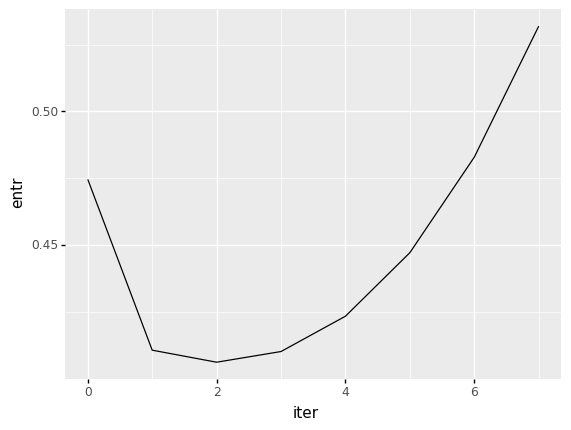

<ggplot: (8792093652351)>

In [18]:
(ggplot(pd.DataFrame(np.hstack((np.arange(len(res[2])).reshape(-1, 1), np.array(res[2]).reshape(-1 ,1))),
            columns=['iter', 'entr'])) +
 geom_line(aes(x='iter', y='entr'))
)



In [19]:
phi_A_all = []
gamma_all = []
for param_val in res[1]:
    phi_A_all.append(param_val['phi_A'].reshape(-1, 1))
    gamma_all.append(param_val['gamma'][0])

phi_A_mat = np.hstack(phi_A_all)
gamma_mat = np.hstack(gamma_all)

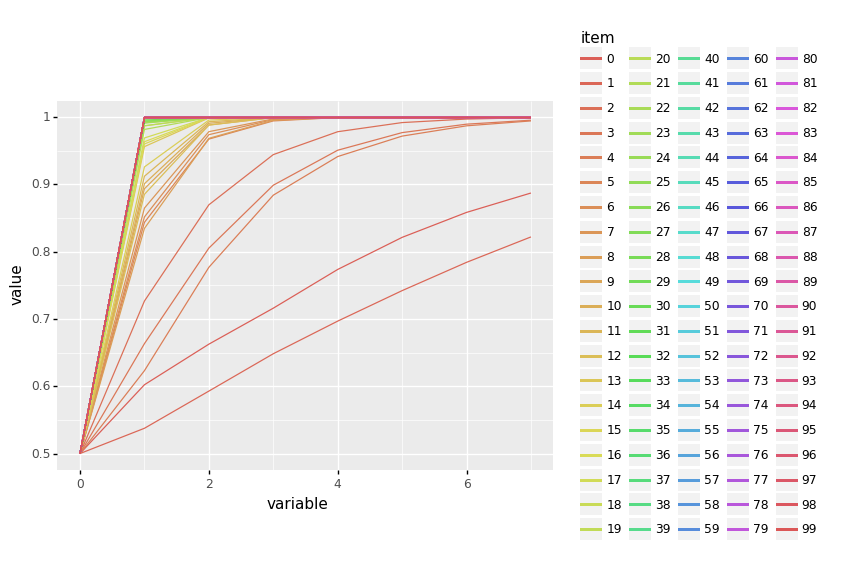

<ggplot: (8792145942700)>

In [20]:
phi_A_pd = pd.DataFrame(phi_A_mat)
phi_A_pd['item'] = np.arange(phi_A_pd.shape[0])
phi_A_pd = pd.melt(phi_A_pd, id_vars=['item'])
phi_A_pd['variable'] = phi_A_pd['variable'].astype(float)
phi_A_pd['item'] = phi_A_pd['item'].astype('category')

(ggplot(phi_A_pd) +
geom_line(aes(x='variable', y='value', color='item'))
)